<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#HR-Problem-solution" data-toc-modified-id="HR-Problem-solution-1">HR Problem solution</a></span><ul class="toc-item"><li><span><a href="#Outline-for-the-solution" data-toc-modified-id="Outline-for-the-solution-1.1">Outline for the solution</a></span></li><li><span><a href="#The-KEY-mistake" data-toc-modified-id="The-KEY-mistake-1.2">The KEY mistake</a></span></li><li><span><a href="#Step-1:-Baseline" data-toc-modified-id="Step-1:-Baseline-1.3">Step-1: Baseline</a></span></li><li><span><a href="#Step-2:-Outliers" data-toc-modified-id="Step-2:-Outliers-1.4">Step-2: Outliers</a></span></li><li><span><a href="#Step-3:-Clustering" data-toc-modified-id="Step-3:-Clustering-1.5">Step-3: Clustering</a></span></li><li><span><a href="#Step-4:-Features-simplification" data-toc-modified-id="Step-4:-Features-simplification-1.6">Step-4: Features simplification</a></span></li><li><span><a href="#Step-5:-Feature-construction" data-toc-modified-id="Step-5:-Feature-construction-1.7">Step-5: Feature construction</a></span></li><li><span><a href="#Step-6:-Search-for-outliers,-again" data-toc-modified-id="Step-6:-Search-for-outliers,-again-1.8">Step-6: Search for outliers, again</a></span></li><li><span><a href="#Step-7:-Binning,-but-without-cheating." data-toc-modified-id="Step-7:-Binning,-but-without-cheating.-1.9">Step-7: Binning, but without cheating.</a></span></li><li><span><a href="#Step-8:-Features-generation" data-toc-modified-id="Step-8:-Features-generation-1.10">Step-8: Features generation</a></span></li><li><span><a href="#Step-9:-Recursive-Feature-Elimination" data-toc-modified-id="Step-9:-Recursive-Feature-Elimination-1.11">Step-9: Recursive Feature Elimination</a></span></li><li><span><a href="#Step-10:-Outliers,-again." data-toc-modified-id="Step-10:-Outliers,-again.-1.12">Step-10: Outliers, again.</a></span></li><li><span><a href="#Evolution-of-Accuracy-through-the-FE-process" data-toc-modified-id="Evolution-of-Accuracy-through-the-FE-process-1.13">Evolution of Accuracy through the FE process</a></span></li></ul></li></ul></div>

# HR Problem solution

Solving the HR problem with Feature Engineering.

In [28]:
# Imports
import warnings

warnings.simplefilter(action='ignore')

from collections import Counter
from copy import copy
from gplearn.genetic import SymbolicTransformer
import pandas as pd
import numpy as np
from tqdm import tnrange, tqdm_notebook, tqdm
from dataset import Dataset
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns; sns.set()
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.cluster import DBSCAN
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, LeaveOneOut, cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KernelDensity
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix
from matplotlib import pyplot

## Outline for the solution

**New features**

- ~~Total hours: years in the company * 12 * average monthly hours. Binned (?)~~
- Some more?

**Group values**

- ~~The projects 2, 6 and 7 were grouped into one category and then dummified.~~
- ~~The departments (product management, R&D, marketing, accounting, management and HR) were merged into one category because they are small departments and have the same behavior or frequency of churn. And then they were dummified.~~

**Play with clusters**

~~Try to add a new label with values for cluster created over: satisfaction + last_evaluation, satisfaction + avg_montly_hours~~

~~**Apply GP**~~

~~**Apply Recursive Feature Elimination**~~



In [29]:
hr = Dataset('data/hr-analytics.zip')
hr.set_target('left')
hr.to_categorical(['promotion_last_5years', 'Work_accident'])
hr.summary()

Features Summary (all):
'satisfaction_level'   : float64    Min.(0.09) 1stQ(0.44) Med.(0.64) Mean(0.61) 3rdQ(0.82) Max.(1.0)
'last_evaluation'      : float64    Min.(0.36) 1stQ(0.56) Med.(0.72) Mean(0.71) 3rdQ(0.87) Max.(1.0)
'number_project'       : float64    Min.(2.0) 1stQ(3.0) Med.(4.0) Mean(3.80) 3rdQ(5.0) Max.(7.0)
'average_montly_hours' : float64    Min.(96.0) 1stQ(156.) Med.(200.) Mean(201.) 3rdQ(245.) Max.(310.)
'time_spend_company'   : float64    Min.(2.0) 1stQ(3.0) Med.(3.0) Mean(3.49) 3rdQ(4.0) Max.(10.0)
'Work_accident'        : object     2 categs. '0.0'(12830, 0.8554) '1.0'(2169, 0.1446) 
'promotion_last_5years': object     2 categs. '0.0'(14680, 0.9787) '1.0'(319, 0.0213) 
'sales'                : object     10 categs. 'sales'(4140, 0.2760) 'accounting'(2720, 0.1813) 'hr'(2229, 0.1486) 'technical'(1227, 0.0818) ...
'salary'               : object     3 categs. 'low'(7316, 0.4878) 'medium'(6446, 0.4298) 'high'(1237, 0.0825) 
'left'                 : float64    Min.(0.0) 

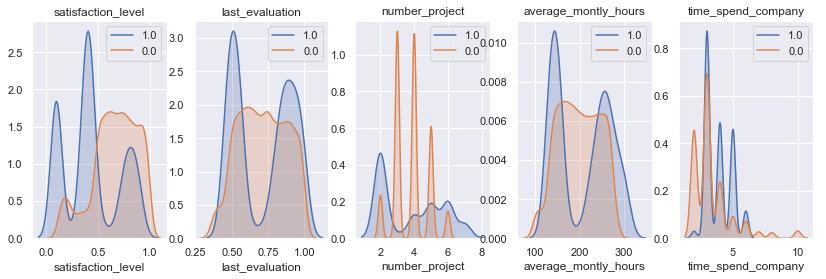

In [30]:
plt.figure(figsize=(14, 4))
num_plots = len(list(hr.numerical))
for index, feature in enumerate(list(hr.numerical)):
    plt.subplot(1, num_plots, index+1)
    hr.plot_double_density(feature)
    plt.legend(loc='best'); plt.ylabel('');
    plt.title(feature)
plt.show();

We cannot do many things from here.

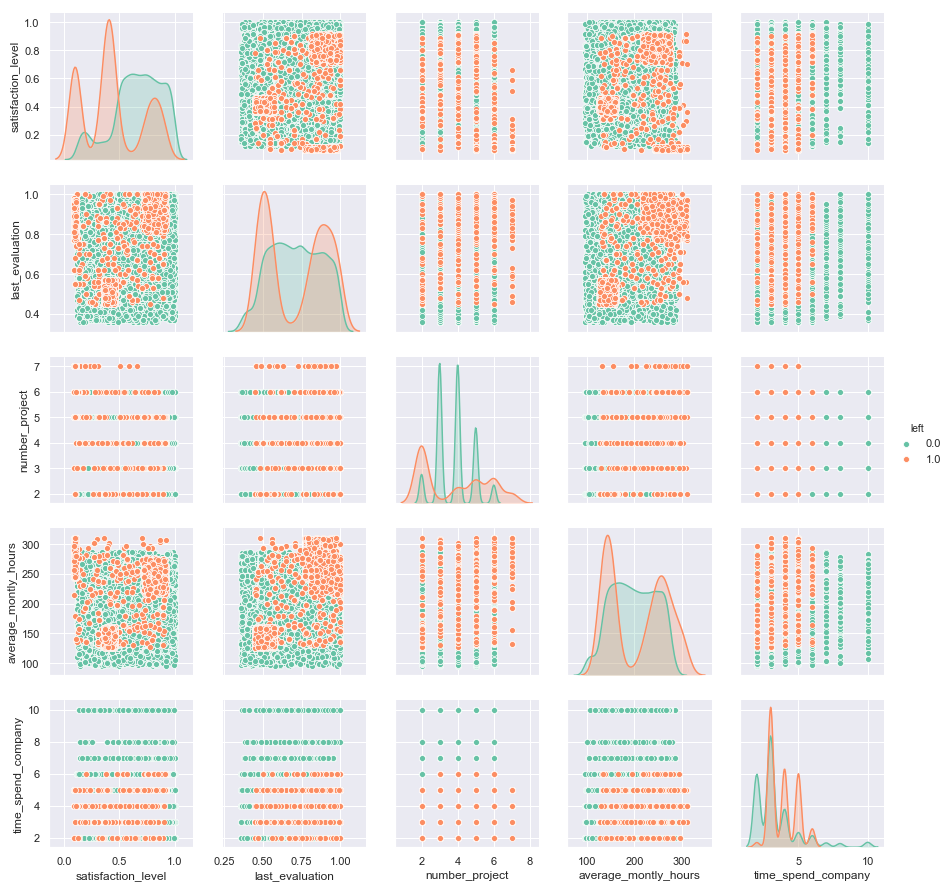

In [31]:
df = pd.concat([hr.features, hr.target], axis=1)
sns.pairplot(df, height=2.5, vars=list(hr.numerical), hue='left', 
             palette="Set2", diag_kind="kde");

## The KEY mistake

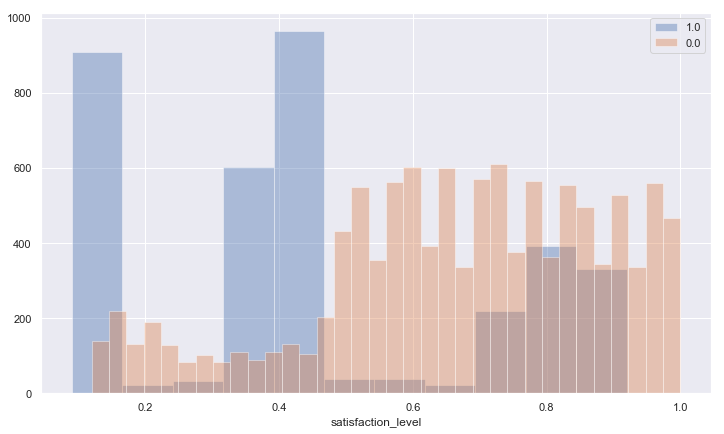

In [32]:
plt.figure(figsize=(12, 7))
hr.plot_double_hist('satisfaction_level')
plt.show();

## Step-1: Baseline

Let's run the logit() against our dataset without any transformation. just the first-step corrections made.

In [33]:
scores = []

def evaluate(df, store=True, verbose=False):
    df_copy = copy(df).scale()
    X, y = df_copy.onehot_encode(list(df.categorical)).split()

    logit = LogisticRegression(random_state=123)
    logit.fit(X.train, y.train)
    accs = cross_val_score(logit, X.train, y.train, cv=5)
    if verbose is True:
        print('Avg accuracy: {:.2f} +/-{:.2f}'.format(
            np.mean(accs), np.std(accs)))

    y_pred = logit.predict(X.test)
    test_score = logit.score(X.test, y.test)
    if verbose is True:
        print('Accuracy on test: {:.2f}'.format(test_score))
    if store is True:
        scores.append(test_score)
    return test_score

evaluate(hr)

0.7896666666666666

## Step-2: Outliers

I will remove outliers to see if that produces some effect in the final score.

In [34]:
hr.drop_samples(hr.outliers())
evaluate(hr)

0.7998638529611981

## Step-3: Clustering

Let's try to add extra information with clustering. I'm using DBScan instead of KMeans, and I'm using 3 features at a time to reduce the dimensionality of the problem. The result is added to the dataset it see if it improves the model metric.

In [35]:
def cluster(X, labels_true, eps=0.3, min_samples=30, verbose=False):
    db = DBSCAN(eps=0.3, min_samples=30).fit(X)
    core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
    core_samples_mask[db.core_sample_indices_] = True
    labels = db.labels_

    # Number of clusters in labels, ignoring noise if present.
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise_ = list(labels).count(-1)

    if verbose is True:
        print('Estimated number of clusters: %d' % n_clusters_)
        print('Estimated number of noise points: %d' % n_noise_)
        print("Homogeneity: %0.3f" %
              metrics.homogeneity_score(labels_true, labels))
        print("Completeness: %0.3f" %
              metrics.completeness_score(labels_true, labels))
        print("Adjusted Mutual Information: %0.3f"
              % metrics.adjusted_mutual_info_score(labels_true, labels))
    return db

In [36]:
variables = ['last_evaluation', 'satisfaction_level', 'average_montly_hours']
db = cluster(hr.features.loc[:, variables], hr.target)
evaluate(hr.add_column(pd.Series(db.labels_, name='eval_sat_hours')))

0.8740639891082369

## Step-4: Features simplification

At this step I simply collapse some values to illustrate that simplifying the problem always helps! This case, we collapse some of the values of `time_spend_company` though this decision is difficult to maintain. The other variable affected is the name of the dpt., that will merge some depts with low significance in attrition.

In [37]:
hr.merge_values('time_spend_company', [2, 7, 8, 10], 1)
hr.merge_categories('sales', ['product_mng', 'RandD',
                              'marketing', 'accounting', 
                              'management', 'hr'], 'staff')
evaluate(hr)

0.8747447243022465

## Step-5: Feature construction

In [38]:
hr.add_column(pd.Series(
    hr.features.time_spend_company * hr.features.average_montly_hours * 12, 
    name='total_hours'))
evaluate(hr)

0.8812117086453369

## Step-6: Search for outliers, again

In [39]:
evaluate(hr.drop_samples(hr.outliers()))

0.8894989704873026

## Step-7: Binning, but without cheating.

Simply bin the continuous information in the dataset to simplify the representation of the problem: I'm trying with 5 equally spaced buckets without CV to find the optimal nr. of them. So, this process could probably lead to better results.

In [40]:
hr.add_column(pd.Series(pd.cut(hr.features.average_montly_hours, 5), 
                        name='AMH', 
                        dtype='object'))
hr.add_column(pd.Series(pd.cut(hr.features.satisfaction_level, 5), 
                        name='SL', 
                        dtype='object'))
hr.add_column(pd.Series(pd.cut(hr.features.last_evaluation, 5), 
                        name='AMH', 
                        dtype='object'));
evaluate(hr)

0.9118050789293068

## Step-8: Features generation

In [41]:
function_set = ['add', 'sub', 'mul', 'div', 'sqrt', 'log', 'abs', 'neg', 
                'inv', 'max', 'min', 'sin', 'cos', 'tan']
gp = SymbolicTransformer(generations=10, population_size=1000,
                         hall_of_fame=100, n_components=12,
                         function_set=function_set,
                         parsimony_coefficient=0.0005,
                         max_samples=0.9, verbose=1,
                         random_state=123, n_jobs=-1)
gp.fit(pd.get_dummies(hr.features), hr.target)
gp_features = gp.transform(pd.get_dummies(hr.features))

    |    Population Average   |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0     8.36 0.11747479818179926        2 0.5691671317107934 0.6071601452160421     22.45s
   1     5.97 0.3062631600899565        7 0.5883302746534435 0.5930252705987735     24.05s
   2     5.02 0.43794344508925825        9 0.6232417390879721 0.6018106539975969     19.81s
   3     4.05 0.4692114959850337        9 0.6319909514532642 0.6579682871779876     15.98s
   4     7.47 0.43973378598154444       12 0.6917567304358636 0.7094484377468712     13.51s
   5    10.86 0.45225871950450597       20 0.7044321742240597 0.6943523883675321     11.20s
   6    14.47 0.4957430221742846       21 0.7337182934548961 0.6980481375782007      8.91s
   7     17.4 0.527017502354248       25 0.7338614670317867 0.7487132351202195      6.05s
   8    21.23 0.57613165

Now, build a dataframe with the new features coming from the GP iterations, add them to the original dataset, and evaluate the new set.

In [42]:
df = pd.DataFrame(gp_features)
df.columns = ['gp{}'.format(i) for i in range(len(list(df)))]
hr.add_columns(df)
evaluate(hr)

0.9461221688400824

## Step-9: Recursive Feature Elimination

As a final step, check if this improves a bit our results. `rfe` is a function that tries RFE() with a given number of final features to be selected. It results the support vector, which is an array of booleans indicating whether a feature at that position should be kept or not. We must simply loop over different values for `num_features` to evaluate what is the test score.

In [43]:
def rfe(ds, num_features):
    estimator = LogisticRegression(random_state=123)
    selector = RFE(estimator, num_features, step=1)
    selector = selector.fit(pd.get_dummies(hr.features), hr.target)
    return selector.support_

In [44]:
hr_dummified = pd.get_dummies(hr.features)
tst_scores_rfe = []
min_range = 7
max_range = 20
for num_features in tqdm_notebook(range(min_range, max_range)):
    best_features = rfe(hr, num_features)
    X = hr_dummified[hr_dummified.columns[best_features]]
    hhr = Dataset.from_dataframe(pd.concat([X, hr.target], axis=1))
    hhr.set_target('left')
    res = evaluate(hhr, store=False)
    tst_scores_rfe.append(res)
    del(hhr)
    del(X)

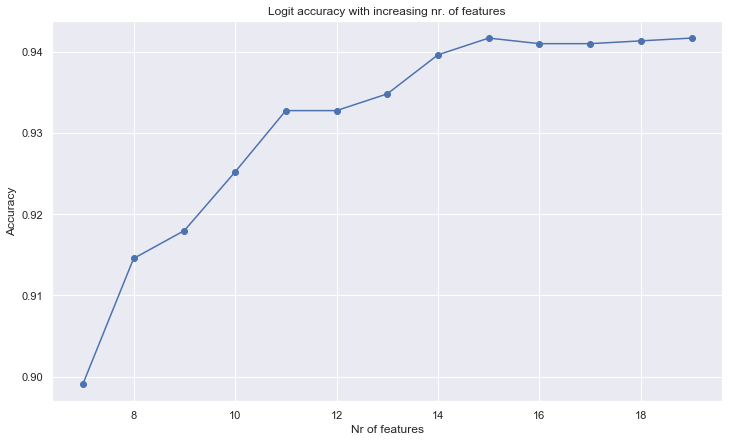

In [45]:
plt.figure(figsize=(12,7))
plt.plot(range(min_range, max_range), tst_scores_rfe, 'o-')
plt.title('Logit accuracy with increasing nr. of features')
plt.ylabel('Accuracy')
plt.xlabel('Nr of features')
plt.show();

Stick only with 18 features, instead of the original 41 features.

In [46]:
hr_dummified = pd.get_dummies(hr.features)
best_features = rfe(hr, 15)
hr_dummified = hr_dummified[hr_dummified.columns[best_features]]
hhr = Dataset.from_dataframe(pd.concat([hr_dummified, hr.target], axis=1))
hhr.set_target('left')
print(evaluate(hhr))

0.9416609471516816


## Step-10: Outliers, again.

Search for outliers, again.

In [47]:
hhr.drop_samples(hhr.outliers())
hhr.describe()
evaluate(hhr)

15 Features. 13354 Samples
Available types: [dtype('float64')]
  · 0 categorical features
  · 15 numerical features
  · 0 categorical features with NAs
  · 0 numerical features with NAs
  · 15 Complete features
--
Target: left (float64)
'left'
  · Min.: 0.0000
  · 1stQ: 0.0000
  · Med.: 0.0000
  · Mean: 0.2518
  · 3rdQ: 1.0000
  · Max.: 1.0000


0.9468363908648446

## Evolution of Accuracy through the FE process

The FE process boosted the performance of the model from 79% accuracy, to **95%**.

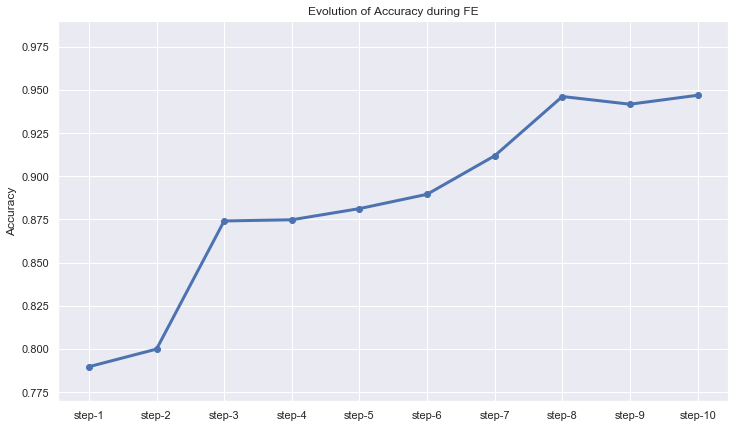

In [48]:
plt.figure(figsize=(12,7))
plt.plot(scores, 'o-', linewidth=3)
plt.ylim(min(scores)-.02, .99)
plt.title('Evolution of Accuracy during FE')
plt.ylabel('Accuracy')
plt.xticks(range(len(scores)), ['step-{}'.format(i+1) for i in range(len(scores))])
plt.show();